코랩 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 #디렉토리가 ~~/notebooks가 되게끔 설정해주세요
 %cd /content/drive/MyDrive/DSL-1/겨울 정규세션/[0227]CNN_FirstnameLASTNAME/notebooks

/content/drive/MyDrive/DSL-1/겨울 정규세션/[0227]CNN_FirstnameLASTNAME/notebooks


# 경로 설정 및 라이브러리/모듈 불러오기

In [3]:
import os

# 디렉토리가 ~~/notebooks가 되게끔 설정해주세요
# os.chdir()
print(os.getcwd())

/content/drive/MyDrive/DSL-1/겨울 정규세션/[0227]CNN_FirstnameLASTNAME/notebooks


In [4]:
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(ROOT_DIR, "data")
weights_dir = os.path.join(ROOT_DIR, "weights")
results_dir = os.path.join(ROOT_DIR, "results")
config_path = os.path.join(ROOT_DIR, "configs", "config.yaml")
metadata_path = os.path.join(ROOT_DIR, "data", "metadata.csv")


# 실제 파일 목록 불러오기
normal_files = os.listdir(os.path.join(data_dir, 'NORMAL'))
pneumonia_files = os.listdir(os.path.join(data_dir, 'PNEUMONIA'))

sys.path.append(os.path.join(ROOT_DIR, "models"))
sys.path.append(os.path.join(ROOT_DIR, "scripts"))
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       image_id class_label  class_id
0  IM-0001-0001      NORMAL         0
1  IM-0003-0001      NORMAL         0
2  IM-0005-0001      NORMAL         0
3  IM-0006-0001      NORMAL         0
4  IM-0007-0001      NORMAL         0
✅ NORMAL 예시: ['IM-0620-0001.jpeg', 'IM-0631-0001-0002.jpeg', 'IM-0626-0001-0001.jpeg', 'IM-0618-0001.jpeg', 'IM-0624-0001-0002.jpeg']
✅ PNEUMONIA 예시: ['person15_bacteria_52.jpeg', 'person1613_virus_2799.jpeg', 'person1609_bacteria_4237.jpeg', 'person1576_bacteria_4122.jpeg', 'person1581_bacteria_4135.jpeg']
✅ 모든 이미지가 성공적으로 매칭되었습니다.


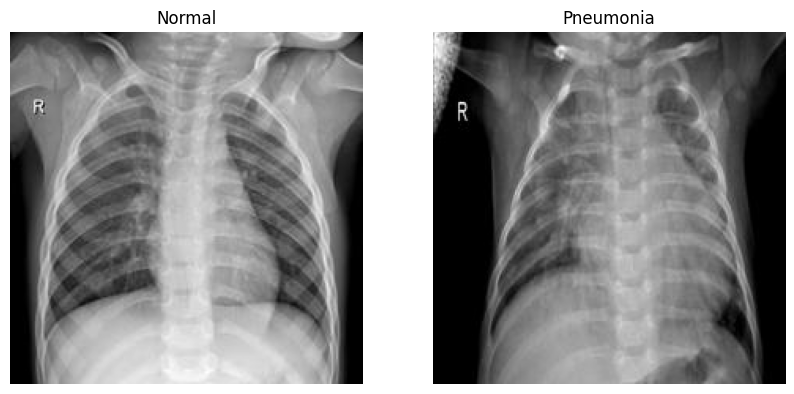

✅ Train 데이터 수: 1920
✅ Validation 데이터 수: 480
✅ Test 데이터 수: 600


In [5]:
from CustomDataset import CustomImageDataset
from resnet import ResNet50

import pandas as pd
import numpy as np

import yaml

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# 하이퍼파라미터 및 기본 설정들

**config.yaml**에 지정해줬던 하이퍼파라미터들을 가져옵시다.

In [6]:
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

batch_size, lr, epochs \
    = config["augmentation"]["hyperparameters"]["batch_size"], \
      float(config["augmentation"]["hyperparameters"]["learning_rate"]), \
      config["augmentation"]["hyperparameters"]["num_epochs"]

In [7]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# num_workers는 dataset의 데이터를 gpu로 전송할 때 필요한 전처리를 수행할 때 사용하는 subprocess의 수입니다
# 참고: https://velog.io/@seokjin1013/PyTorch-numworkers%EC%97%90-%EA%B4%80%ED%95%98%EC%97%AC
num_workers = min(4, os.cpu_count() // 2)
print(num_workers)

4


# train, val, test DataLoader 초기화

In [9]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다

metadata = pd.read_csv(metadata_path)
print(metadata.head())


# 파일명을 metadata에 매칭하는 함수
def match_file(row):
    folder = 'NORMAL' if row['class_label'] == 'NORMAL' else 'PNEUMONIA'
    files_list = normal_files if folder == 'NORMAL' else pneumonia_files

    # image_id와 매칭되는 파일 찾기
    for file in files_list:
        if row['image_id'] in file:
            return os.path.join(folder, file)  # 폴더명 포함된 상대 경로 반환
    return None  # 일치하는 파일이 없는 경우

# metadata 업데이트
metadata['matched_image_path'] = metadata.apply(match_file, axis=1)


# 매칭된 경로만 사용
matched_metadata = metadata.dropna(subset=['matched_image_path'])


# train : val : test = 6 : 2 : 2
train, val_test = train_test_split(matched_metadata, train_size=0.6, random_state=2025)
val, test = train_test_split(val_test, train_size=0.5, random_state=2025)

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(data_dir=data_dir, df=train, augment=True)
val_dataset   = CustomImageDataset(data_dir=data_dir, df=val, augment=False)
test_dataset  = CustomImageDataset(data_dir=data_dir, df=test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

       image_id class_label  class_id
0  IM-0001-0001      NORMAL         0
1  IM-0003-0001      NORMAL         0
2  IM-0005-0001      NORMAL         0
3  IM-0006-0001      NORMAL         0
4  IM-0007-0001      NORMAL         0


# 모델 초기화, 손실함수 및 optimizer 지정

In [10]:
from resnet import ResNet50
import torch.nn as nn

model = ResNet50()
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, mo

In [37]:
# 손실함수와 optimizer를 정의합니다
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train

In [68]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# 모든 epoch에서의 loss와 accuracy들을 저장할 리스트들
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for curr_epoch in range(epochs): # iterate over all EPOCHS
    running_loss, total_correct, total_samples = 0, 0, 0 # 현재 epoch에서의 train_loss와 train_accuracy들을 계산하기 위한 변수들

    for batch_idx, (img, label) in enumerate(train_loader): # iterate over all BATCHES
        # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
        img, label = img.to(device), label.to(device)

        # Forward Propagation
        pred = model(img)

        # 손실함수 계산
        loss = criterion(pred, label.view(-1,1).float()) # 구현 상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

        # 누적된 기울기 초기화 및 역전파
        optimizer.zero_grad()
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 해당 Batch에서의 loss를 running_loss 변수에 누적
        running_loss += loss.item()

        # Accuracy 계산
        predicted = (torch.sigmoid(pred).view(-1) > 0.5).float()  # (batch_size, 1) → (batch_size,)
        #predicted = (torch.sigmoid(pred) > 0.5).float()
        label = label.view(-1).float()  # 동일한 형태로 변환
        total_correct += (predicted == label).sum().item()
        total_samples += label.size(0)  # 전체 배치 사이즈 사용

    # 모든 Batch를 순회한 이후 최종적인 train_loss, train_accuracy를 계산해줍니다
    train_loss = running_loss / len(train_loader)
    train_accuracy = total_correct / total_samples


    # Validation 시작
    model.eval()

    with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
        running_loss, total_correct, total_samples = 0, 0, 0 # 현재 epoch에서의 val_loss와 val_accuracy들을 계산하기 위한 변수들

        for img, label in val_loader: # iterate over all BATCHES
            # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
            img, label = img.to(device), label.to(device)

            # Forward Propagation
            pred = model(img)

            # 손실함수 계산
            loss = criterion(pred, label.view(-1,1).float()) # 구현 상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

            # 해당 Batch에서의 loss를 running_loss 변수에 누적
            running_loss += loss.item()

            # 예측값 및 Accuracy 계산
            predicted = (torch.sigmoid(pred).view(-1) > 0.5).float()  # (batch_size, 1) → (batch_size,)
            #predicted = (torch.sigmoid(pred) > 0.5).float()
            label = label.view(-1).float()  # 동일한 형태로 변환
            total_correct += (predicted == label).sum().item()
            total_samples += label.size(0)  # 전체 배치 사이즈 사용

        # 모든 Batch를 순회한 이후 최종적인 train_loss, train_accuracy를 계산해줍니다
        val_loss = running_loss / len(val_loader)
        val_accuracy = total_correct / total_samples


    model.train()  # 모델을 다시 학습모드로 설정합니다

    # 현재 epoch에서의 결과들 출력
    print(f"Epoch [{curr_epoch + 1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    # 리스트에 저장
    train_loss_list.append(train_loss)
    valid_loss_list.append(val_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(val_accuracy)

    # 가장 작은 validation loss를 가졌을 때의 모델 파라미터를 "best_model_augmentation.pth"로 저장해줍니다.
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weights_dir, "best_model_augmentation.pth"))


Epoch [1/10] | Train Loss: 0.1712 | Train Accuracy: 0.9328 | Val Loss: 0.2444 | Val Accuracy: 0.9167
Epoch [2/10] | Train Loss: 0.1955 | Train Accuracy: 0.9189 | Val Loss: 0.2442 | Val Accuracy: 0.9067
Epoch [3/10] | Train Loss: 0.1912 | Train Accuracy: 0.9211 | Val Loss: 0.2418 | Val Accuracy: 0.9050
Epoch [4/10] | Train Loss: 0.2006 | Train Accuracy: 0.9206 | Val Loss: 0.2660 | Val Accuracy: 0.8967
Epoch [5/10] | Train Loss: 0.1882 | Train Accuracy: 0.9239 | Val Loss: 0.2449 | Val Accuracy: 0.9050
Epoch [6/10] | Train Loss: 0.1872 | Train Accuracy: 0.9244 | Val Loss: 0.2396 | Val Accuracy: 0.9083
Epoch [7/10] | Train Loss: 0.1715 | Train Accuracy: 0.9289 | Val Loss: 0.2329 | Val Accuracy: 0.9117
Epoch [8/10] | Train Loss: 0.1764 | Train Accuracy: 0.9228 | Val Loss: 0.2268 | Val Accuracy: 0.9150
Epoch [9/10] | Train Loss: 0.1768 | Train Accuracy: 0.9344 | Val Loss: 0.2290 | Val Accuracy: 0.9167
Epoch [10/10] | Train Loss: 0.1844 | Train Accuracy: 0.9300 | Val Loss: 0.2385 | Val Accura

# Train 결과 시각화 및 그래프 저장

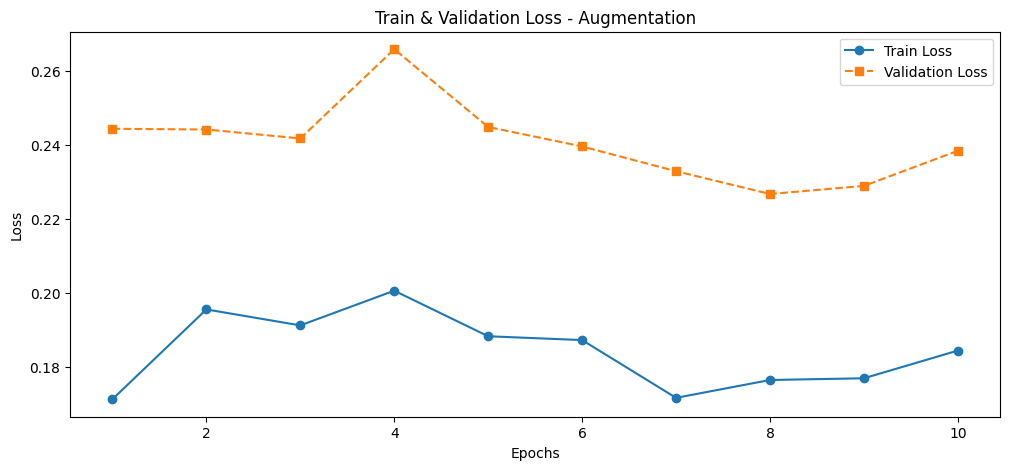

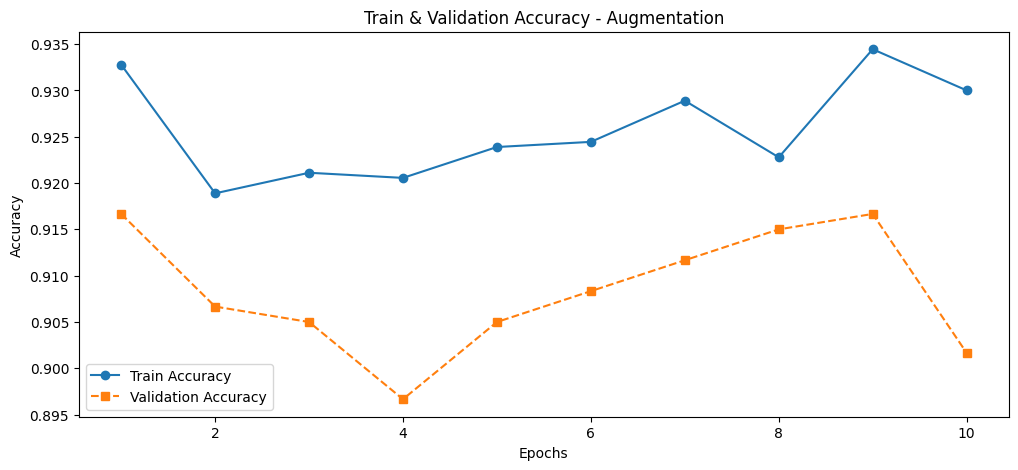

In [69]:
# Train Loss & Validation Loss 그래프 시각화 및 저장
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), valid_loss_list, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Validation Loss - Augmentation')
plt.legend()
plt.savefig(os.path.join(results_dir, "train_validation_loss_augmentation.png"))
plt.show()
plt.close()

# Train Accuracy & Validation Accuracy 그래프 시각화 및 저장
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), valid_accuracy_list, label='Validation Accuracy', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy - Augmentation')
plt.legend()
plt.savefig(os.path.join(results_dir, "train_validation_accuracy_augmentation.png"))
plt.show()
plt.close()


# Test 및 Test 결과 시각화

In [70]:
from resnet import ResNet50
import torch.nn as nn

# ✅ 모델 초기화
trained_model = ResNet50()

# ✅ conv1 입력 채널 확인 (필요 시 3으로 변경)
trained_model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

# ✅ 출력층 재정의 (이진 분류용)
trained_model.fc = nn.Linear(512 * 4, 1)

# ✅ 가중치 로드 (키 불일치 허용)
trained_model.load_state_dict(
    torch.load(os.path.join(weights_dir, "best_model_augmentation.pth"), map_location=device),
    strict=True
)

# ✅ GPU 전송 및 평가 모드
trained_model.eval()
trained_model.to(device)

print("✅ 모델 로딩 및 초기화 완료 🎉")


✅ 모델 로딩 및 초기화 완료 🎉


<ipython-input-70-f39c7746c007>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(weights_dir, "best_model_augmentation.pth"), map_location=device),


In [71]:
all_labels = []
all_predictions = []

with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    for image, label in test_loader:
        # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
        image, label = image.to(device), label.to(device)

        # Forward Propagation
        pred = trained_model(image)

        # 예측값 계산
        predicted = (torch.sigmoid(pred) > 0.5).float()

        # 리스트에 저장
        all_labels.append(label)
        all_predictions.append(predicted)

all_labels = torch.cat(all_labels).cpu().numpy().tolist()
all_predictions = torch.cat(all_predictions).cpu().numpy().tolist()

Accuracy: 93.00%


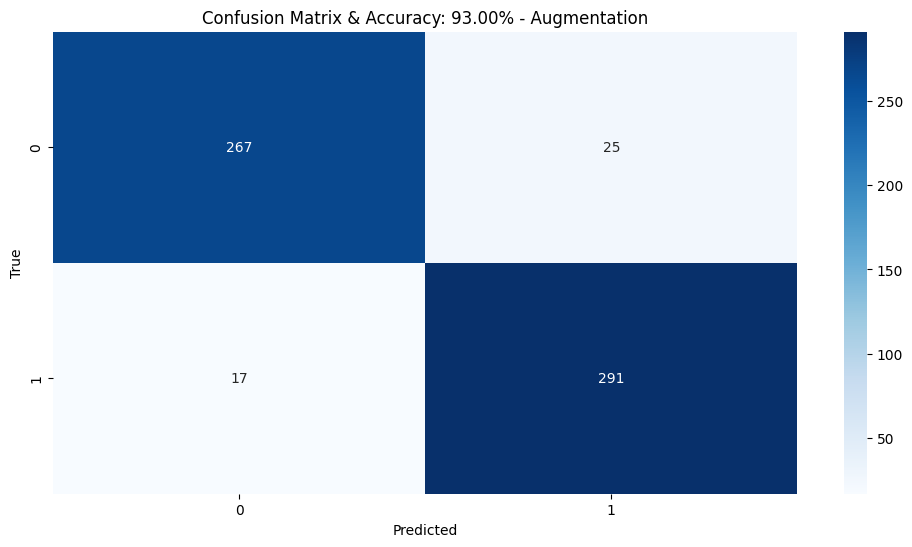

In [72]:
# Accuracy 계산 및 Confusion Matrix 계산
accuracy = accuracy_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

# Confusion Matrix 시각화 및 저장

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion Matrix & Accuracy: {accuracy * 100:.2f}% - Augmentation')
plt.savefig(os.path.join(results_dir, "test_accuracy_augmentation.png"))
plt.show()
plt.close()